In [1]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [2]:
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_subset_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 1996
end_year = 2015
exclude_countries = []
pickle_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2'
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
plm_formula = 'ENI ~ lag(ENI, 1:2) + POP + AFL + AFL2 + URB + CTS + TI + KAOPEN | lag(ENI, 2:99)'
plm_params = {
    'effect': 'twoways',
    'model': 'twostep',
    'collapse': False,
    'transformation': 'd',
}

In [3]:
# Parameters
dataset_file = "/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv"
index_fields = ["Country", "Year"]
data_fields = ["ENI", "POP", "URB", "AFL", "TI", "TS", "CTS", "KAOPEN"]
prefix = "template"
start_year = 1997
end_year = 2015
exclude_countries = []
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
pickle_file = "/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_1997_2015.pickle.bz2"


**End of parameter section** 

In [4]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get pdynmc_params plm_formula plm_params

# SoS mangles dict keys, for no apparent reason
names(pdynmc_params) <- gsub('_', '.', names(pdynmc_params))
names(plm_params) <- gsub('_', '.', names(plm_params))

suppressMessages({
library(dplyr)
library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))

Country,min,max
<fct>,<int>,<int>
ALB,1997,2011
ARG,1997,2014
ARM,2005,2014
AUS,1997,2015
AUT,1997,2015
AZE,2001,2014


In [5]:
pdynmc_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] FALSE

$use.mc.nonlin
[1] FALSE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"    "AFL"    "AFL2"   "URB"    "CTS"    "TI"     "KAOPEN"

$lagTerms.reg.fur
[1] 0 0 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "twostep"

$opt.meth
[1] "none"

$inst.stata
[1] FALSE

In [6]:
pdynmc_base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(pdynmc_base_params, pdynmc_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary


Dynamic linear panel estimation (twostep)
Estimation steps: 2

Coefficients:
           Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)    
L1.ENI     0.476813    0.108165       4.408        1e-05 ***
L2.ENI     0.042413    0.046421       0.914       0.3607    
L0.POP    -0.087375    0.206315      -0.424       0.6716    
L0.AFL    -0.073170    0.503767      -0.145       0.8847    
L0.AFL2   -0.029015    0.025678      -1.130       0.2585    
L0.URB     0.210010    0.374981       0.560       0.5755    
L0.CTS     0.041180    0.016171       2.547       0.0109 *  
L0.TI     -0.007472    0.009595      -0.779       0.4360    
L0.KAOPEN -0.001834    0.005788      -0.317       0.7512    
2000      -0.011133    0.008769      -1.270       0.2041    
2001       0.011252    0.012714       0.885       0.3762    
2002       0.017860    0.015333       1.165       0.2440    
2003       0.043317    0.019116       2.266       0.0234 *  
2004       0.045711    0.021729       2.104       0.0354 *  
2005   


Call:
lm(formula = residuals ~ fitted, data = pdynmc_resid)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.42592 -0.02691 -0.00083  0.02806  0.23982 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.019895   0.002222  -8.952   <2e-16 ***
fitted      -0.452962   0.036487 -12.414   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05311 on 1243 degrees of freedom
  (195 observations deleted due to missingness)
Multiple R-squared:  0.1103,	Adjusted R-squared:  0.1096 
F-statistic: 154.1 on 1 and 1243 DF,  p-value: < 2.2e-16


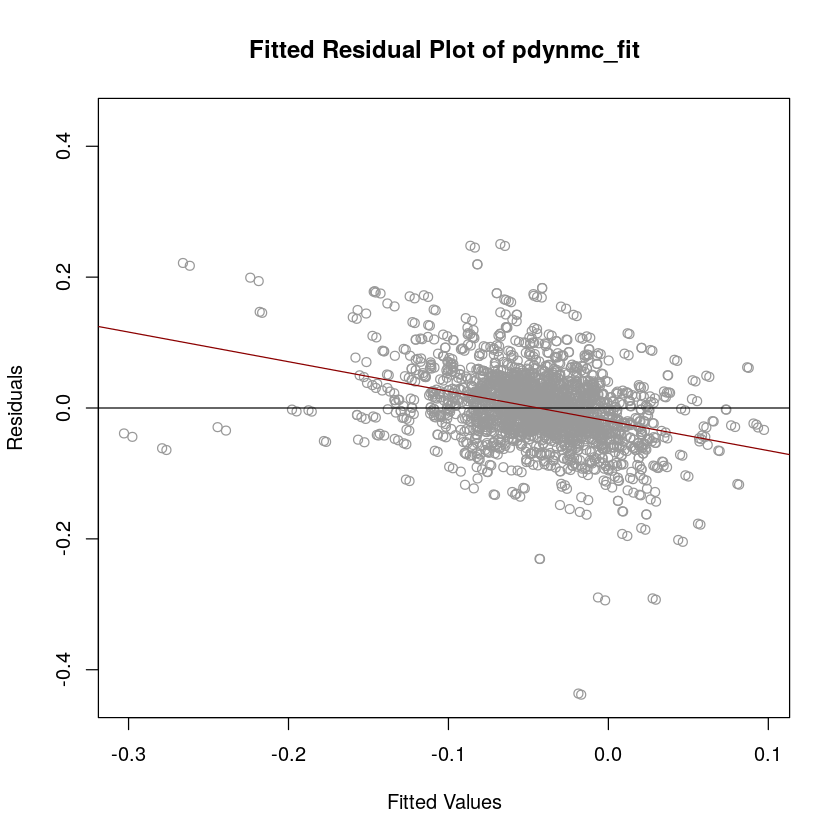

In [7]:
pdynmc_resid <- data.frame(residuals=unlist(residuals(pdynmc_fit)),
                           fitted=unlist(fitted.values(pdynmc_fit)))
resid.reg <- lm(residuals ~ fitted, data=pdynmc_resid)
plot(pdynmc_fit)
abline(resid.reg, col='darkred')
summary(resid.reg)

In [8]:
jtest.fct(pdynmc_fit)
ser.corr1 <- mtest.fct(pdynmc_fit, t.order = 1)
ser.corr1
ser.corr2 <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr2


	J-Test of Hansen

data:  2step GMM Estimation; H0: overidentifying restrictions valid
chisq = 77.418, df = 150, p-value = 1


Warning message in mtest.fct(pdynmc_fit, t.order = 1):
“Absolute value of denominator of test statistic was used in the computation.”



	Arrelano and Bond (1991) serial correlation test of degree 1

data:  2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
normal = -4.4179, p-value = 9.965e-06



	Arrelano and Bond (1991) serial correlation test of degree 2

data:  2step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = 1.0808, p-value = 0.2798


In [9]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr1, ser.corr2),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,77.417861,chisq,9.999998e-01,2step GMM Estimation; H0: overidentifying restrictions valid
Wald test,439.764118,chisq,4.419686e-89,2step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,54.728257,chisq,3.940767e-06,2step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 1,-4.417930,normal,9.965080e-06,2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
Arrelano and Bond (1991) serial correlation test of degree 2,1.080773,normal,2.797982e-01,2step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [10]:
# plm.formula <- as.formula(plm_formula)
# plm.params = modifyList(list(plm.formula,
#                              data=data.panel),
#                         plm_params)
# z2 <- do.call(pgmm, plm.params)
# z2$call <- plm.formula
# summary(z2, robust = TRUE)

In [11]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)

In [12]:
%get pdynmc_coef pdynmc_tests pdynmc_resid --from R
import pickle
import bz2

with bz2.BZ2File(pickle_file, 'w') as fd:
    pickle.dump({
        'pdynmc_coef': pdynmc_coef,
        'pdynmc_tests': pdynmc_tests,
        'pdynmc_resid': pdynmc_resid,
        'pdynmc_params': pdynmc_params,
        'start_year': start_year,
        'end_year': start_year,
        'varname.reg.fur': start_year,
        'start_year': start_year,
    }, fd)